In [50]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import numpy as np
from tqdm.notebook import tqdm

from utils import seed_everything, Timer

In [51]:
seed_everything(3407)
# CIFAR-10
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
                               transforms.Resize(224)])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [52]:
from transformers import ViTForImageClassification


model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")
model.classifier = nn.Linear(768, 10)
model.to('cuda:0')
model.config.id2label = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4,
                         5: 5, 6: 6, 7: 7, 8: 8, 9: 9}

In [54]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

for epoch in range(1):  #
    running_loss = 0.0
    for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
        inputs, labels = data
        inputs, labels = inputs.to('cuda:0'), labels.to('cuda:0')
        optimizer.zero_grad()
        outputs = model(inputs).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(trainloader)}")

In [55]:
model.to('cpu')
model_dir = 'checkpoint'
model.save_pretrained(model_dir)

  0%|          | 0/157 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Inference | Elapsed time : 119.56
Accuracy: 0.9426751592356688
Precision: 0.9458421797593771
Recall: 0.9426751592356688
F1-Score: 0.943220533819745


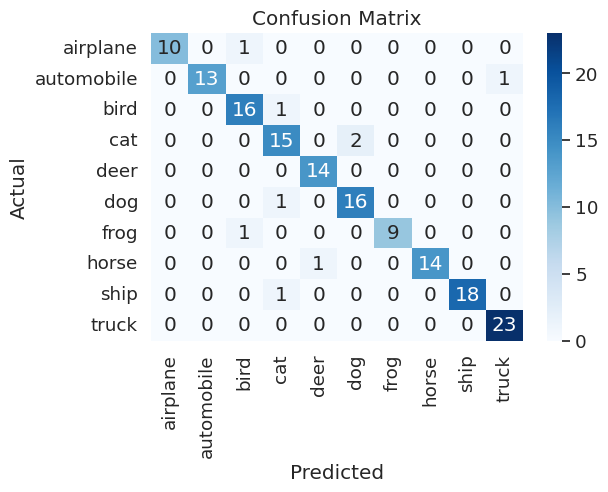

In [75]:
# Testing
def evaluate_cifar(net):
    net.eval()
    all_labels = []
    all_predictions = []

    with Timer('inference', True) as timer:
        with torch.inference_mode():
            for data in tqdm(testloader):  #
                inputs, labels = data
                # inputs, labels = inputs.to('cuda:0'), labels.to('cuda:0')
                inputs = inputs[0].unsqueeze(0)
                outputs = net(inputs)
                _, predicted = torch.max(outputs.logits, 1)
                all_labels.append(labels[0].item())
                all_predictions.append(predicted.item())

    # Metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")

    # Confusion matrix
    plt.figure(figsize=(6, 4))
    sns.set(font_scale=1.2)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=testset.classes, yticklabels=testset.classes)

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

evaluate_cifar(model)

# Optimum

In [ ]:
# !pip install onnxruntime onnx

In [42]:
# !python -m pip install git+https://github.com/huggingface/optimum-intel.git

In [76]:
from optimum.pipelines import pipeline


base_pipeline = pipeline(
    task='image-classification',
    model=model_dir,
    image_processor='google/vit-base-patch16-224',
    framework='pt',
    device='cpu',
    accelerator="ort",
)

Framework not specified. Using pt to export to ONNX.
Using the export variant default. Available variants are:
	- default: The default ONNX variant.
Using framework PyTorch: 2.1.0+cu118
/usr/local/lib/python3.10/dist-packages/transformers/models/vit/modeling_vit.py:170: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if num_channels != self.num_channels:
/usr/local/lib/python3.10/dist-packages/transformers/models/vit/modeling_vit.py:176: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if height != self.image_size[0] or width != self.image_size[1]:


  0%|          | 0/157 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Inference | Elapsed time : 97.67
Accuracy: 0.9426751592356688
Precision: 0.9458421797593771
Recall: 0.9426751592356688
F1-Score: 0.943220533819745


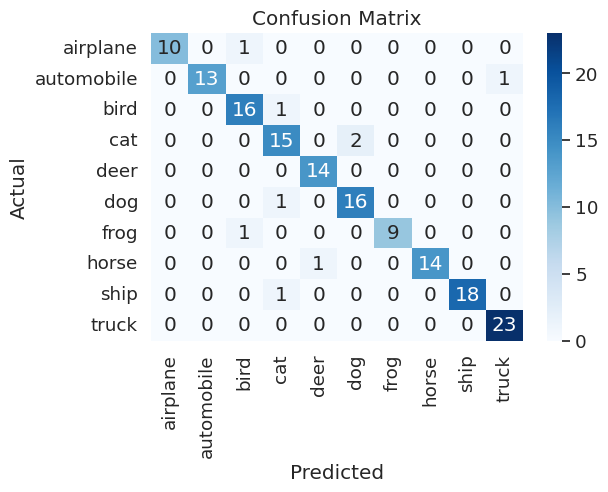

In [78]:
# Testing
def evaluate_cifar_optimum(base_pipeline):
    all_labels = []
    all_predictions = []

    with Timer('inference', True) as timer:
        with torch.inference_mode():
            for data in tqdm(testloader):  #
                inputs, labels = data
                inputs = transforms.ToPILImage()(inputs[0])
                outputs = base_pipeline(images=inputs)[0]['label']
                all_labels.append(labels[0])
                all_predictions.append(outputs)

    # Metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")

    # Confusion matrix
    plt.figure(figsize=(6, 4))
    sns.set(font_scale=1.2)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=testset.classes, yticklabels=testset.classes)

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

evaluate_cifar_optimum(base_pipeline)

# Optimum optimization

In [79]:
import onnxruntime
from optimum.onnxruntime import ORTModelForImageClassification, ORTOptimizer
from optimum.onnxruntime.configuration import OptimizationConfig

session_options = onnxruntime.SessionOptions()
session_options.log_severity_level = 0
optimum_pipe_1 = ORTModelForImageClassification.from_pretrained(
    model_id=model_dir,
    export=True,
    provider="CPUExecutionProvider",
    session_options=session_options
)

In [80]:
import onnxruntime
from optimum.onnxruntime import ORTModelForImageClassification, ORTOptimizer
from optimum.onnxruntime.configuration import OptimizationConfig

session_options = onnxruntime.SessionOptions()
session_options.log_severity_level = 0
optimum_pipeline = ORTModelForImageClassification.from_pretrained(
    model_id=model_dir,
    export=True,
    provider="CPUExecutionProvider",
    session_options=session_options
)

Framework not specified. Using pt to export to ONNX.
Using the export variant default. Available variants are:
	- default: The default ONNX variant.
Using framework PyTorch: 2.1.0+cu118
/usr/local/lib/python3.10/dist-packages/transformers/models/vit/modeling_vit.py:170: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if num_channels != self.num_channels:
/usr/local/lib/python3.10/dist-packages/transformers/models/vit/modeling_vit.py:176: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if height != self.image_size[0] or width != self.image_size[1]:


In [81]:
optimization_config = OptimizationConfig(
    optimization_level=99
)
optimizer = ORTOptimizer.from_pretrained(optimum_pipeline)
optimizer.optimize(save_dir='optimum_model', optimization_config=optimization_config)
optimum_model = ORTModelForImageClassification.from_pretrained('optimum_model')

/usr/local/lib/python3.10/dist-packages/optimum/onnxruntime/configuration.py:765: FutureWarning: disable_embed_layer_norm will be deprecated soon, use disable_embed_layer_norm_fusion instead, disable_embed_layer_norm_fusion is set to True.
  warnings.warn(
Optimizing model...
Configuration saved in optimized_model/ort_config.json
Optimized model saved at: optimized_model (external data format: False; saved all tensor to one file: True)


In [82]:
optimum_pipeline = pipeline(
    "image-classification",
    model=optimum_model,
    image_processor='google/vit-base-patch16-224',
    feature_extractor='google/vit-base-patch16-224',
    accelerator="ort",
    device='cpu'
)

  0%|          | 0/157 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Inference | Elapsed time : 76.43
Accuracy: 0.9426751592356688
Precision: 0.9458421797593771
Recall: 0.9426751592356688
F1-Score: 0.943220533819745


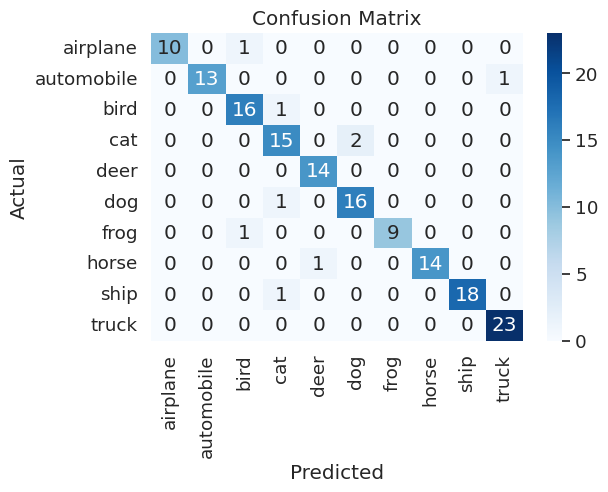

In [84]:
evaluate_cifar_optimum(optimum_pipeline)

# Results


Улучшили время на инферинсе на 30%, при этом прогнозы вышли точь в точь такие же. Но у нас была небольшая выборка (иначе можно умереть с VIT на колаб)